In [1]:
%matplotlib inline
import numpy
import sympy
sympy.init_printing()  # to get nice latex-formatted output

# README

This notebook is based on Ch1 of the FEniCS book [1] - a tutorial guiding new users through the process of using FEniCS. It will attempt to run through the same process and examples in Firedrake.

!!!!!!!!!!!!!!    PLEASE RUN WITH PYTHONDRAKE KERNEL    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[1] Anders Logg, Kent-Andre Mardal, and Garth Wells. 2012. Automated Solution of Differential Equations by the Finite Element Method: The FEniCS Book. Springer Publishing Company, Incorporated.

# 1 - A FEniCS Tutorial

## 1.1 Fundamentals

The following chapter will work through a series of simple examples, in order to demonstrate:

* defining a PDE in terms of a variational problem
* defining simple domains
* dealing with Dirichlet, Neumann and Robin conditions
* dealing with variable coefficients
* computing derived quantities like the flux vector field or a functional of the solution
* how to quickly vizualise the mesh, solution, flux, etc...
* solving *nonlinear* PDEs in various ways
* dealing with time-dependent PDEs
* setting parameters governing solution methods for linear systems
* creating domains of more complex shape

The mathematics is intentionally kept simple to focus on the functionality and syntax of FEniCS. Mostly the Poisson equation and time-dependent diffusion equation will be our model problems.

### 1.1.1 The Poisson Equation

We will whistle through this as it's already been covered in my notes on FEM theory. The Poisson problem is:

\begin{align}
-\Delta u &= f \text{ in } \Omega, \\
u &= u_0 \text{ on } \delta\Omega.
\end{align}

Where $u = u(x)$ is the unknown function, $f = f(x)$ is given, $\Omega$ is the spatial domain and $\delta\Omega$ its boundary.

(In 2 dimensions we'd have $u = u(x,y), f = f(x,y)$ etc....)

Solving a physical problem with FEniCS consists of the following steps:

1. Identify the PDE and its boundary conditions.

1. Reformulate the PDE as a variational problem.

1. Write a Python program where the forumlae in the variational problem are coded, along with definitions of inputs such as $f, u_0$ and a mesh for $\Omega$.

1. Add statements in the program for solving the variational problem, computing derived quantities (e.g. $\Delta u$, and for visualising the results.

We will go through steps 2-4 in detail - the key in FEniCS is that 3 and 4 are fairly compact and easy to code.

### 1.1.2 Variational formulation

FEniCS easily solves PDEs if finite elements are used for discretization *in space* and the problem is expressed in variational form.

For the Poisson equation, we multiply by the test function $v$ in some function space $\hat{V}$ and integrate:

$$ - \int_{\Omega} (\Delta u)v dx = \int_{\Omega} fv dx $$

Then integrate by parts to get:

$$ = - \int_{\Omega} (\Delta u)v dx = \int_{\Omega}\nabla u \cdot \nabla v dx - \int_{\partial\Omega} \frac{\partial u}{\partial n}v ds $$

Since $v$ is required to vanish on all parts of the boundary where $u$ is known, we have that $v = 0$ everywhere on $\partial\Omega$. So we are left with:

$$ - \int_{\Omega} \nabla u \cdot \nabla v dx = \int_{\Omega}fv dx \quad \forall v \in \hat{V}$$

The trial function $u$ lies in a function space $V$:

\begin{align}
    V &= \{v \in H^1(\Omega) : v = u_0 \text{ on } \partial\Omega \} \\
    \hat{V} &= \{ v \in H^1(\Omega) : v = 0 \text{ on } \partial\Omega \}
\end{align}

To solve numerically, we transform this continuous variational problem into a discrete one, by introducing *finite-dimensional* test and trial spaces $V_h \subset V$ and $\hat{V}_h \subset \hat{V}$. Then we solve the discrete variational problem of finding $u_h \in V_h \subset V$ such that:

$$ - \int_{\Omega} \nabla u_h \cdot \nabla v dx = \int_{\Omega}fv dx \quad \forall v \in \hat{V}_h \subset \hat{V}$$

The mathematical literature on variational problems writes $u_h$ for the solution of the discrete problem, and $u$ for the solution of the continuous problem. To obtain an (almost) 1-1 correspondence between the mathematical formulation of a problem, and the FEniCS/Firedrake program, we shall use $u$ for the solution of the discrete problem and $u_e$ for the exact solution of the continuous problem, **if we need to distinguish explicitly between the two**. In most cases, we will introduce the PDE problem with $u$ as unknown, derive a variational equation $a(u,v) = L(v)$ with $u \in V$ and $v \in \hat{V}$ and then simply discretize by saying that we choose finite-dimensional spaces for $v$ and $\hat{V}$. This restriction implies that $u$ **becomes a discrete finite element function**.

**In practise** this means we turn our PDE problem into a continuous variational problem, create a mesh and specify an element type, and then let $V$ correspond to this mesh and element choice. Depending on whether $V$ is finite- or infinite-dimensional, $u$ will be the exact or approximate solution.

#### Unified weak form notation:

It will be convenient to introduce a unified notation for the weak variational problem:


$$ a(u,v) = L(v) $$

In the Poisson problem above we have:

\begin{align}
    a(u,v) &= \int_{\Omega} \nabla u \cdot \nabla v dx, \\
    L(v) &= \int_{\Omega} fv dx.
\end{align}

===================================================================================================================

**In every linear problem we will identify the terms with unknown $u$ and collect them in $a(u,v)$, and collect all the terms with only known functions in $L(v)$.**

===================================================================================================================

### 1.1.3 Implementation

We don't yet have specific choices for $\Omega, f, u_0$. To solve the problem we need to specify these. We will choose an example wherein we can easily check the computed answer is correct. Suppose we wanted the exact solution to be:

$$ u_e(x,y) = 1 + x^2 + 2y^2 $$

on some 2D domain. Inserting this into the Poisson problem we can see that this $u_e(x,y)$ is a solution of:

\begin{align}
    f(x,y) &= -6 \\
    u_0(x,y) &= u_e(x,y) = 1 + x^2 + 2y^2
\end{align}

on any 2D domain of any shape. We can choose a unit square for simplicity:

$$ \Omega = [0,1] \times [0,1] $$

**Remark:** We chose the particular form of $u_e$ above because the FEM with a rectangular domain uniformly partitioned into linear triangular elements will *exactly reproduce a second-order polynomial at the verticies of the cells*, regardless of the size of the elements. Thus we can verify our numerical solution $u$ by comparing it to $u_e$ at the nodes, where they should be equal to machine precision.

A Firedrake program for solving the Poisson equation in 2D with the above choices of $\Omega, f, u_0$ looks like:

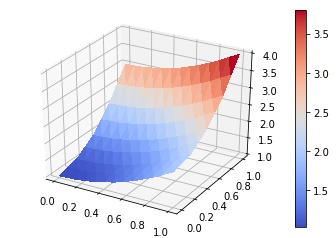

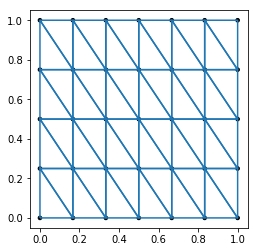

In [5]:
#[1]pg5

from firedrake import *

# Create a mesh and define function space
mesh = UnitSquareMesh(6,4)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx

# Define boundary conditions
u0 = Expression("1 + x[0]*x[0] + 2*x[1]*x[1]")
bc = DirichletBC(V, u0, (1, 2, 3, 4))

# Compute solution
u = Function(V)
solve(a == L, u, bcs=[bc])

# Plot solution and mesh
plot(u, plot3d=True)
plot(mesh)

# Save solution to file
File("/home/alexander/Documents/QMEE/Firedrake Learning/Ch1_tutorial_saves/1.1.3_poisson.pvd").write(u)

This is a direct adaptation of the example FEniCS code in the FEniCS book referenced in the readme at the top of this notebook. All our example code (unless explicitly stated) will be taken from this book and modified to work in firedrake syntax. The top comment will provide the pageref of the original FEniCS example code in the book.

### Dissection

We shall now dissect this Firedrake program in detail:

```python
from firedrake import *
```
simply imports the key classes `UnitSquareMesh()`, `FunctionSpace()`, `Function()`, etc... from the Firedrake library.

We need a mesh on which to solve our problem using FEM:

```python
# Create a mesh...
mesh  = UnitSquareMesh(6,4)
```
defines a uniform finite element mesh over the unit square $[0,1] \times [0,1]$. This mesh consists of triangular cells. The parameters 6 and 4 tell us that the unit square is first divided into  $6 \times 4$ rectangles, and then each rectangle is divided into 2 triangles. The total number of triangles is then 48, and the total number of verticies in the mesh is $7 \times 5 = 35$.

With a mesh defined, we need to build the function spaces in which our solution will live in, along with the spaces for the trial and test functions. For a scalar variable (i.e. one which is described by only a single value at each point in the domain), we do this with `FunctionSpace()`:

```python
#...and define the function space.
V = FunctionSpace(mesh, "Lagrange", 1)
```
The second argument reflects the type of finite element and the third is the degree of the basis functions on the element. Here we use "Lagrange" (equivalently "CG" - 'Continuous Galerkin'), the standard Lagrange family of elements. With degree 1, we get the standard linear Lagrange element (a triangle with a node at each vertex). The computed solution $u$ will therefore be linearly varying in $x$ and $y$ over each cell in the mesh.

**Remark:** Higher degree polynomial approximations over each cell can be trivially obtained by increasing the first parameter in `FunctionSpace()`.

**Remark:** Mathematically, we usually distinguish between the trial and test spaces $V$ and $\hat{V}$, defined for this problem as:

\begin{align}
    V &= \{v \in H^1(\Omega) : v = u_0 \text{ on } \partial\Omega \} \\
    \hat{V} &= \{ v \in H^1(\Omega) : v = 0 \text{ on } \partial\Omega \}
\end{align}

Notice that they therefore *only differ on the boundary conditions*, which are not specified in `FunctionSpace()`. Hence, for this example, we can write the Firedrake code with one common space $V$.

Now that we have the function spaces that our solution will live in, we must express our problem in the correct variational form. This requires a test function $v$, a trial function $u$ (since $u$ is unknown) and a function to hold the RHS $f$:
```python
# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
```
We can then express the problem in the correct variational form using $a(u,v)$ and $(L(v)$ as explained above:
```python
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx
```


We now discuss the boundary conditions, which can enter a variational problem in 2 ways. **Natural** (equivalently *Neumann* or *weak*), **which prescribe values of the derivative of the solution**, are incorporated into the variational form itself. **Essential** (equivalently *Dirichlet* or *strong*), **which prescribe values of the solution**, become prescriptions on the function space. In Firedrake we represent the latter as `DirichletBC` objects and apply them when calling the solver on the variational problem.

To construct a Dirichlet boundary condition we require a function space (describing the functions to which the boundary condition is imposed), a value, and a subdomain (describing *where* the boundary condition is imposed):
```python
bc = DirichletBC(V, value, subdomain_id)
```

`value` can be simply a scalar, or more generally an `Expression`, `Function` or `Constant` of the appropriate shape.

`subdomain_id` is an integer (or collection of integers) indicating which section of the mesh the boundary condition should be applies to. The subdomain ids for various meshes are described in their respective constructor documentation (e.g. `UnitSquareMesh`).

We defined ours by first defining an expression $u_0$ and then passing this to `DirichletBC`:
```python
# Define boundary conditions
u0 = Expression("1 + x[0]*x[0] + 2*x[1]*x[1]")
bc = DirichletBC(V, u0, (1, 2, 3, 4))
```

Finally, we have defined everything we need to begin solving our problem with FEM. Our problem is linear (linear in both the test and trial functions and $L$ is linear in the test function), so we can use the linear variational problem interface to `solve()`. We will first need a `Function` object to hold the value of the solution, and then we can call `solve()` on the variational form, including boundary conditions:
```python
# Compute solution
u = Function(V)
solve(a == L, u, bcs=[bc])
```

Notice that we appear to redefine $u$ as a `Function` object containing the solution, whereas previously it was a `TrialFunction` used to represent the unknown in the form $a$. Python allows this kind of redefinition and since the two objects referred to by $u$ represent the same mathematical object, we are happy to do this.

The simplest way of quickly looking at the solution $u$ and the mesh is:
```python
plot(u)
plot(mesh)
```

#### Advanced solver parameters

Above, we used a compact syntax to obtain our solution:
```python
solve(a == L, u bcs=[bc])
```

There is a more comprehensive syntax which allows us to choose specific parameters by passing a dictionary to the `solver_parameters` argument, for example:
```python
solve(a == L, u, bcs=[bc], solver_parameters={'ksp_type': 'cg'})
```



### 1.1.6 Examining the Discrete Solution

Recall that we built our example in Section 1.1.3 above so that the computed solution $u$ would equal the exact solution $u_e$ *at the verticies of the cells*. We should therefore examine the computed values of the solution to check if this is indeed the case.

A finite element function like $u$ is expressed as a linear combination of basis functions $\phi_j$ spanning the space $V$:

$$ \sum_{j=1}^N U_j \phi_j $$

WHen we write `solve(a == L, u, bcs=[bc])` in the program, a linear system will be formed from $a$ and $L$ and solved for the $U_1, ... , U_N$ values, or **degrees of freedom** of $u$. For Lagrange (and many other element types), $U_k$ is simply the value of $u$ at the node with global number $k$.

$u$ is currently a `Function` object in Firedrake. We can either evaluate $u(x,y)$ directly at any point (or collection thereof) in the mesh, using `.at()`:

In [29]:
u.at([0,0])

array(1.0000000000000027)

In [91]:
u.at([0,0], [1,0])

[array(1.0000000000000027), array(2.000000000000001)]

or we can grab all the values $U_j$ directly:

In [93]:
u_nodal_values = u.vector()

The result is a Firedrake `Vector` object. We can convert this to a standard numpy array for ease of processing:

In [38]:
u_array = u_nodal_values.array()

array([ 1.        ,  1.125     ,  1.02777778,  1.15277777,  1.11111111,
        1.5       ,  1.23611109,  1.52777776,  1.25      ,  2.125     ,
        1.37499993,  1.61111115,  2.15277778,  1.44444444,  3.        ,
        1.56944442,  1.75      ,  2.23611118,  3.02777778,  1.69444444,
        1.81944441,  1.94444448,  2.375     ,  3.11111111,  2.        ,
        2.125     ,  2.19444439,  2.56944446,  3.25      ,  2.5       ,
        2.81944446,  3.44444444,  3.125     ,  3.69444444,  4.        ])

For verification purposes we can interpolate $u_0$ across V and compare the values of $u$ and $u$ at the nodes (we expect error only at the level of machine precision $10^{-16}$:

In [96]:
u_nodes = numpy.array(u.at([0,0],[1,0],[0,1],[1,1]))
u_e = interpolate(u0, V)
u_e_nodes = numpy.array(u_e([[0,0],[1,0],[0,1],[1,1]]))

print ("Max error = ", numpy.abs(u_e_nodes - u_nodes).max())

Max error =  4.4408920985e-16


Yay!

### 1.1.7 Solving a real physical problem!

The above was a profoundly simplistic problem - we now proceed to solving a real, physical problem. This is just a matter of specifying a more exciting domain, boundary condition(s) and right-hand side $f$.

We will take the following physical problem, regarding the warping $D(x,y)$ of an elastic circular membrane with radius $R$, subject to a localised perpendicular pressure force, modelled as a Gaussian function. The appropriate PDE model is:

$$ -T\Delta D = p(x,y) \quad \text{in } \Omega = \{ (x,y) \mid x^2 + y^2 \leq R \}, $$

with

$$ p(x,y) = \frac{A}{2\pi\sigma}\exp \Bigg(-\frac{1}{2} \bigg(\frac{x - x_0}{\sigma} \bigg)^2 -\frac{1}{2} \bigg( \frac{y - y_0}{\sigma} \bigg)^2 \Bigg) $$

Here, $T$ is the tension in the membrane (constant), $p$ is the external pressure load, $A$ the amplitude of the pressure, $(x_0, y_0)$ the localisation of the Gaussian pressure function, and $\sigma$ the "width" of this function.

The boundary of the membrane will have no deflection, so that $D = 0$ is a boundary condition.

We will actually solve a rescaled version of the problem to get rid of some of the annoying variables:

$$ -\Delta w = f $$

with $w=0$ on the boundary and with

$$ f(x,y) = 4 \exp \Bigg(-\frac{1}{2} \Big(\frac{Rx - x_0}{\sigma} \Big)^2 -\frac{1}{2} \Big(\frac{Ry-y_0}{\sigma} \Big)^2 \Bigg) $$

We solve using much the same framework as before:

sigma =  0.0025 
max deviation =  0.994430802611


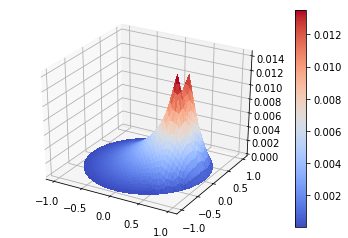

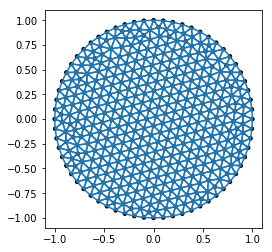

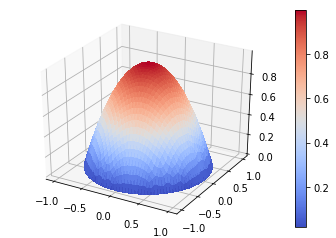

In [14]:
from firedrake import *

#Initialise R, x0, y0 and sigma
R = 0.3  #radius of domain
theta = 0.2
x0 = 0.6*R*cos(theta)
y0 = 0.6*R*sin(theta)
sigma = 0.0025  # set >=50 for verification on a "flat" pressure

#Create the mesh and define the function space
mesh = Mesh("/home/alexander/Documents/QMEE/Firedrake Learning/circle.msh")  # Here we import a circular mesh made in gmsh
V = FunctionSpace(mesh, "Lagrange", 1)

#Define the variational problem
w = TrialFunction(V)
v = TestFunction(V)
f = Expression("4 * exp(-0.5 * pow((R * x[0] - x0)/sigma , 2) - 0.5 * pow((R * x[1] * y0)/sigma, 2))",
              R=R, x0=x0, y0=y0, sigma=sigma)  # define defaults for the parameters inside the new expression object (it can't see their existing values unless they're passed to it directly)
f = interpolate(f,V)
a = inner(nabla_grad(w), nabla_grad(v))*dx
L = f*v*dx

#Define boundary condition
bc = DirichletBC(V, Constant(0), (1))

#Compute solution
w = Function(V)
solve(a == L, w, bcs = [bc])

#Plot the solution and mesh
plot(w, plot3d=True)
plot(mesh)

# Save solution to file
File("/home/alexander/Documents/QMEE/Firedrake Learning/Ch1_tutorial_saves/1.1.6_membrane.pvd").write(w)

#Verification
w_exact = Expression("1 - x[0]*x[0] - x[1]*x[1]")
w_e = interpolate(w_exact, V)
dev = numpy.abs(w_e.vector().array() - w.vector().array()).max()
plot(w_e, plot3d=True)
print("sigma = ", sigma, "\nmax deviation = ", dev)

### 1.1.9 Computing Derivatives 

Often we will want to compute derivatives of the solution, such as the gradient. The computation is conceptually simple:

$$ w = \sum_{j=1}^N U_j \phi_j \quad \implies \quad \nabla w = \sum_{j=1}^N U_j \nabla \phi_j $$

However, recall that our solution $u$ is only piecewise continuous - in our particular case of using Lagrangian elements of degree 1, $u$ is linear over each cell, and the numerical $\nabla u$ becomes a piecewise constant vector field. Conversely, the exact gradient is of course smooth. We therefore want the computed gradient to be a continuous vector field, and we typically want each component of $\nabla u$ to be represented in the same way as $u$ itself. We can achieve this by *projecting* the components of $\nabla u$ onto the same function space that we used for $u$ - i.e. by solving $\omega = \nabla w$ with the FEM.

Looking at the component $\frac{\partial w}{\partial x}$ of the gradient, we project the (discrete) derivative $\sum_j U_j \frac{\partial \phi_j}{\partial x}$ onto a function space with basis $\phi_1, \phi_2, ...$ such that the derivative in this space is expressed by the standard sum $\sum_j \bar{U}_j \phi_j$ for new coefficients $\bar{U}_j$.

The new variational problem reads: find $\omega \in V^{(g)}$ such that:

$$ a(\omega, v) = L(v) \quad \forall v \in \hat{V}^{(g)} $$

where

\begin{align}
    a(\omega,v) &= \int_{\Omega} \omega \cdot v dx \\
    L(v) &= \int_{\Omega} \nabla u \cdot v dx
\end{align}

The function spaces $V^{(g)}$ and $\hat{V}^{(g)}$ (where the $g$ denotes "gradient") are vector versions of the function space for $w$, with boundary conditions removed (if $V$ is the space we used for $w$, with no restrictions on boundary values, $V^{(g)} = \hat{V}^{(g)} = [V]^d$, where $d$ is the number of space dimensions. For example if we used piecewise linear functions on the mesh to approximate $w$, the variational problem for $\omega$ corresponds to approximating each component field of $\omega$ by piecewise linear functions.

The variational problem for $\omega$ is solved thus in Firedrake:

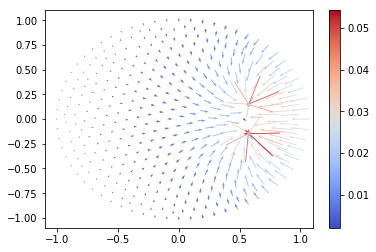

In [18]:
V_g = VectorFunctionSpace(mesh, "Lagrange", 1)
omega = TrialFunction(V_g)
v = TestFunction(V_g)

a = inner(omega, v)*dx
L = inner(grad(w), v)*dx

omega = Function(V_g)
solve(a == L, omega)

plot(omega)

In [40]:
omega_x, omega_y = split(omega)
plot(omega_x)
#omega_x, omega_y = omega.split()  # extract components
#plot(omega_x)
#plot(omega_y)

NotImplementedError: Cannot take length of non-vector expression.